In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from z3 import *
from IPython.display import Markdown, display,IFrame,HTML,Image
from skimage.morphology import label
from scipy.ndimage import measurements

### Puzzle as published 
https://www.janestreet.com/puzzles/knight-moves-2-index/

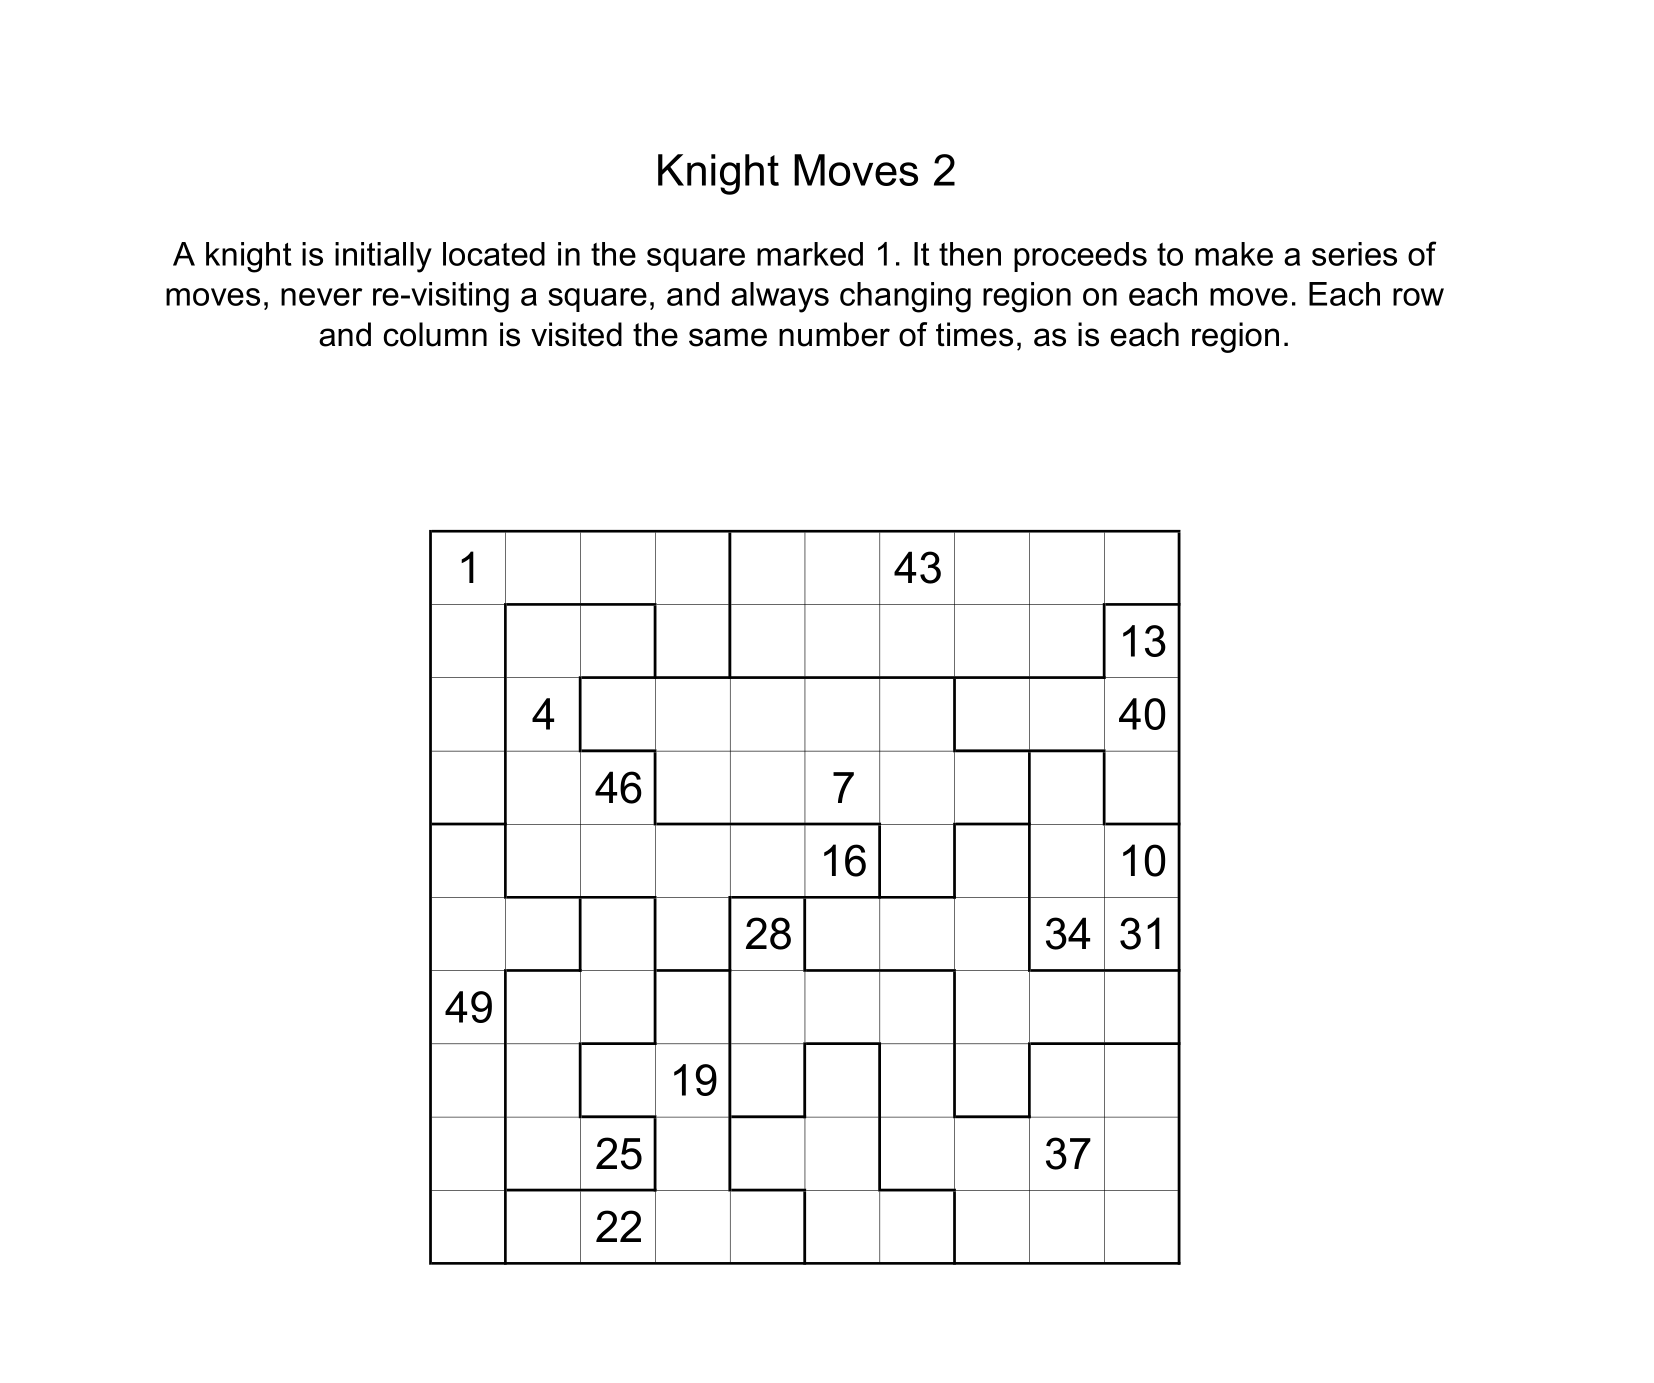

In [2]:
url='https://www.janestreet.com/puzzles/knight-moves-2-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
tags=soup.findAll('img')
for match in tags:
    match.decompose()

display(Markdown('### Puzzle as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/Apr17__puzzle.png',width=400))
HTML(str(soup.find_all('div', {'class' :'col-12'})[4]))

In [3]:
# Setup the constraints
# Smallest group has 5 cells.
# 12 hooks so max moves = 60
# so 6 in each row and col

groups =np.array([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
                  [0, 2, 2, 0, 1, 1, 1, 1, 1, 3],
                  [0, 2, 4, 4, 4, 4, 4, 3, 3, 3],
                  [0, 2, 2, 4, 4, 4, 4, 4, 5, 3],
                  [6, 2, 2, 2, 2, 2, 4, 7, 5, 5],
                  [6, 6, 8, 2,10, 7, 7, 7, 5, 5],
                  [6, 8, 8, 9,10,10,10, 7, 7, 7],
                  [6, 8, 9, 9,10,11,10, 7,10,10],
                  [6, 8, 8, 9,11,11,10,10,10,10],
                  [6, 9, 9, 9, 9,11,11,10,10,10]
                 ],dtype=int)

fixed =np.array([[ 1,  0,  0,  0,  0,  0, 43,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 13],
                 [ 0,  4,  0,  0,  0,  0,  0,  0,  0, 40],
                 [ 0,  0, 46,  0,  0,  7,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0, 16,  0,  0,  0, 10],
                 [ 0,  0,  0,  0, 28,  0,  0,  0, 34, 31],
                 [49,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0],
                 [ 0,  0, 25,  0,  0,  0,  0,  0, 37,  0],
                 [ 0,  0, 22,  0,  0,  0,  0,  0,  0,  0]]
                 ,dtype=int)

Solution **17,280** took 1.9269 seconds

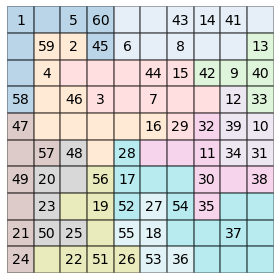

In [18]:
def moves(i,j,N):
    moves=[(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
    return [(i+x,j+y) for x,y in moves if i+x >=0 and i+x<N and j+y>=0 and j+y<N ]

def areas(grid):
        labels, num = measurements.label(grid==0)
        a= measurements.sum(grid==0, labels, index=range(1, num+1))
        return np.prod(a)

start = time.time()
N= 10
s = Tactic("qffd").solver()

#set up grid
X = np.array(IntVector('x', N*N),dtype=object).reshape((N,N))         
s += [X[i,j] == int(e) for (i,j),e in np.ndenumerate(fixed) if e !=0]

#knight moves
s += [Or(e==0,e==1,PbEq([(X[k,l]==e-1,1) for k,l in moves(i,j,N)],1)) for (i,j),e in np.ndenumerate(X)] 

# 12 regions largest is 5 cells so use 60 (needs to be divisible by 10). Make distinct
nums = 5*12
s += [And(e >= 0 ,e <= nums) for (i,j),e in np.ndenumerate(X)]
s += [PbEq([(e==n,1) for (i,j),e in np.ndenumerate(X)],1) for n in range(1,nums+1)]

# rows and cols
for n in range(N):
    s += PbEq([(e==0,1) for (i,j),e in np.ndenumerate(X) if i == n],int(10-nums/10))
    s += PbEq([(e==0,1) for (i,j),e in np.ndenumerate(X) if j == n],int(10-nums/10))

# groups visited same number of times
for g in range(12):
    s += PbEq([(e!=0,1) for (i,j),e in np.ndenumerate(X) if groups[i,j] == g],int(nums/12))
    
if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    x =  evalu(X)
    display(Markdown("Solution **{:,.0f}** took {:.4f} seconds".format(areas(x),time.time()-start)))
    pretty = np.vectorize(lambda x:(' '+str(int(x))).replace(' 0','').replace(' ',''))
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    ax = sns.heatmap(groups,
                     annot=pretty(x),
                     fmt='',cbar=False,
                     cmap='tab20',linecolor='k',linewidth=2,
                     annot_kws={"fontsize":14,"color":"k"},alpha=0.3)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Failed in {:.4f} seconds".format(time.time()-start))       

### Puzzle as published 
https://www.janestreet.com/puzzles/knight-moves-2-solution/

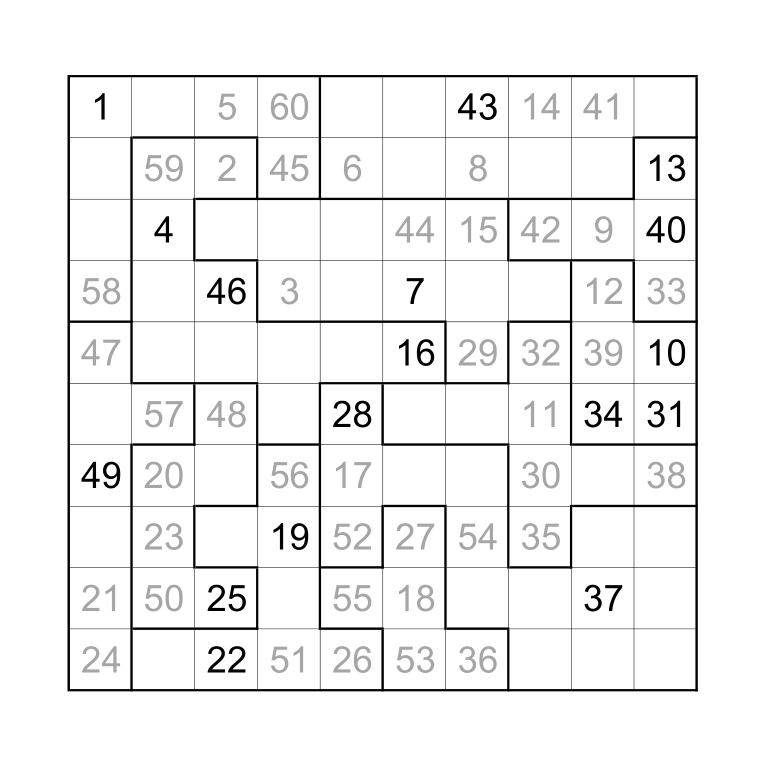

In [5]:
url='https://www.janestreet.com/puzzles/knight-moves-2-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
tags=soup.findAll('img')
for match in tags:
    match.decompose()

display(Markdown('### Puzzle as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/Apr17_solution.png',width=400))
HTML(str(soup.find_all('div', {'class' :'col-12'})[4]))